# Fig. 4. Convergent connectivity mapping of antidepressant effects without weighting by sample size

In [18]:
# set_env.py is not included in the repo
# it defines $HCP_DENSE_PATH, $PROJECT_DIR (required) and $HCP_DIR (optional)
# in environment variables
import set_env

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nilearn.plotting
import surfplot
import pyvirtualdisplay

# create virtual display for plotting meshes in remote servers
disp=pyvirtualdisplay.Display(visible=False)
disp.start()

sys.path.append('../scripts')
from helpers import io, transform, plot
from ccm import ccm

plt.rcParams.update({"font.size": 12, "font.family": "Asana Math", "figure.dpi": 192})

### Left. Convergent connectivity map plot

Calculate convergent connectivity Z map:

In [4]:
zmap_all = ccm.ccm_random('All', n_perm=1000, weighted=True)

Results will be saved in /data/group/cng/Projects/Amin/antidepressants_ale/public/scripts/helpers/../../results/ccm/ccm_random_weighted_n-1000/All/


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Calculating true FC


100%|████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.41it/s]


Points: 512 of 528
Closest distance of included points (in mm)
 count    512.000000
mean       2.957853
std        2.279893
min        0.000000
25%        1.100348
50%        2.257545
75%        4.422846
max        9.922255
dtype: float64


100%|████████████████████████████████████████████████████████████| 1000/1000 [04:03<00:00,  4.10it/s]


Plot:

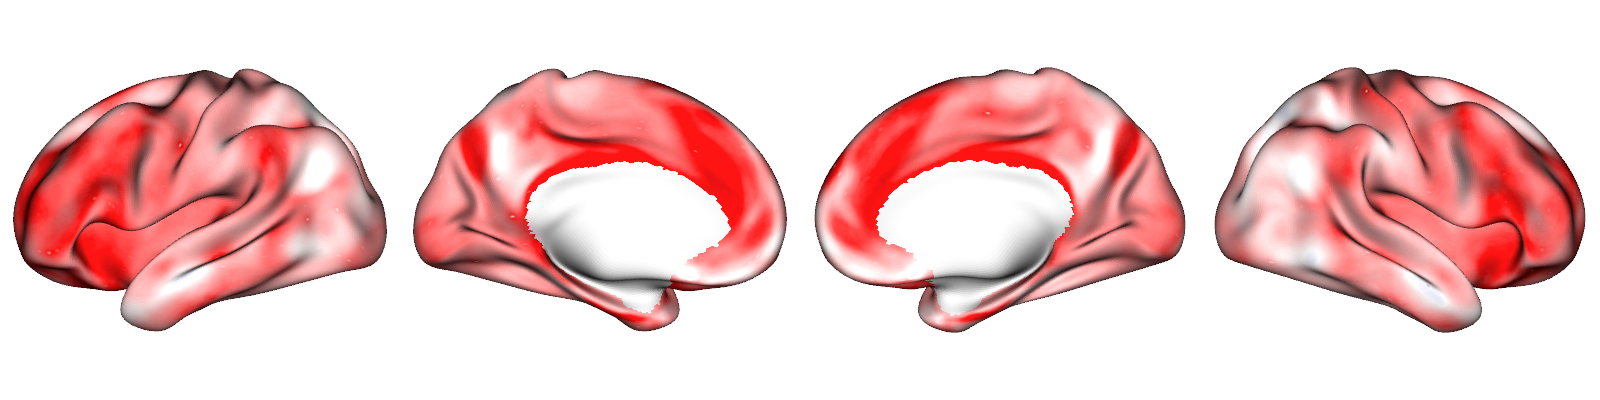

In [5]:
# convert cortical to fsLR and plot
zmap_all_fslr = transform.cifti_to_fsLR(zmap_all)
# whole-brain color range
vmin = min(np.nanmin(zmap_all), -np.nanmax(zmap_all))
vmax = -vmin
plot.plot_surface(zmap_all_fslr, cmap='seismic_light', nan_color=(0.9, 0.9, 0.9, 1), vrange=(vmin, vmax))

/data/group/cng/Projects/Amin/antidepressants_ale/venv/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


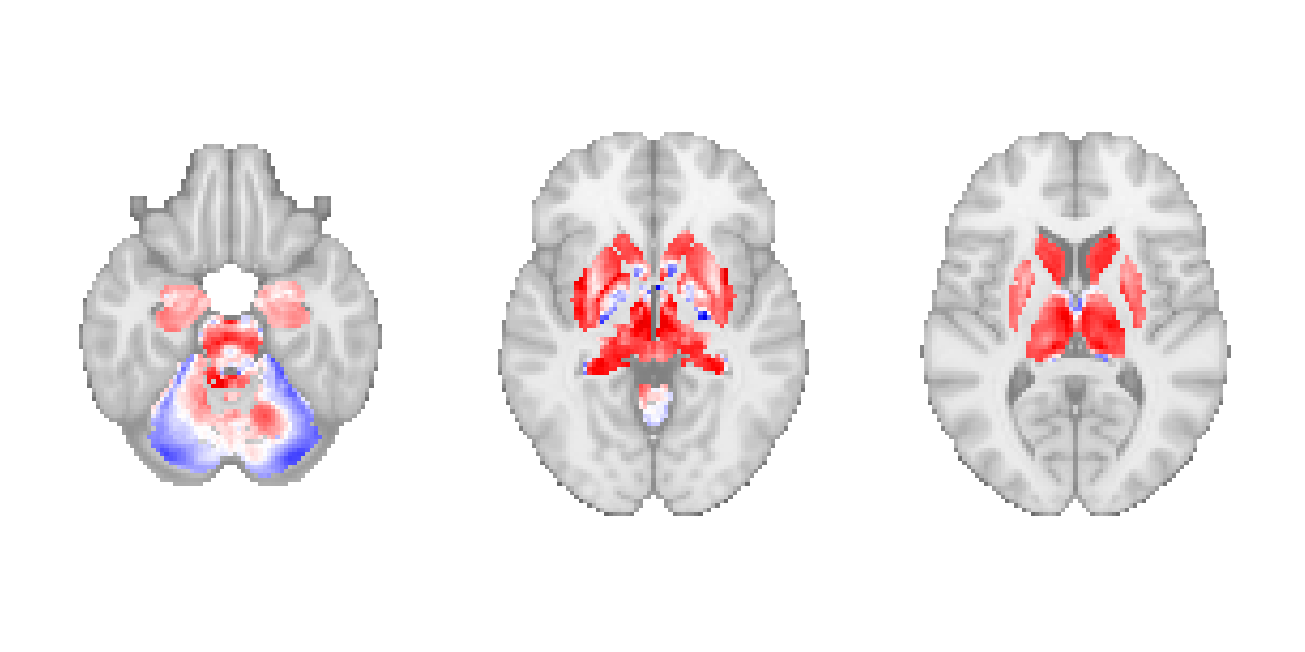

In [6]:
# map to MNI
zmap_all_mni = transform.cifti_to_mni(zmap_all, exc_cortex=True)
nilearn.plotting.plot_stat_map(zmap_all_mni, display_mode='z', cut_coords=[-22, -4, 8], 
                               cmap='seismic_light', vmax=vmax, colorbar=False, annotate=False)

In [7]:
print(-vmax, vmax)

-3.0905291379252677 3.0905291379252677


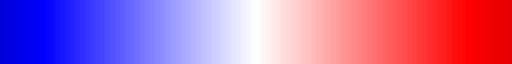

In [8]:
sns.color_palette('seismic_light', as_cmap=True)

### Right. Convergent connectivity to resting-state networks

In [19]:
true_fc = np.load(os.path.join(io.RESULTS_DIR, 'ccm', 
                       'ccm_random_weighted_n-1000',
                       'All', 'true_fc-mean.npy'
                  ))
null_fcs = np.load(os.path.join(io.RESULTS_DIR, 'ccm', 
                       'ccm_random_weighted_n-1000',
                       'All', 'null_fcs.npy'
                  ))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
/data/group/cng/Projects/Amin/antidepressants_ale/public/scripts/figures/../ccm/ccm.py:314: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  true_fc_yeo = pd.DataFrame(true_fc_fslr, index=yeo_map.categorical).reset_index().groupby('index').mean()
/data/group/cng/Projects/Amin/antidepressants_ale/public/scripts/figures/../ccm/ccm.py:315: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  null_fcs_yeo = pd.DataFrame(null

,mean,p_vals
VIS,0.283254,0.114219
SMN,0.314123,0.099301
DAN,0.264260,0.172827
SAN,0.280872,0.059441
LIM,0.181377,0.059441
FPN,0.229991,0.027972
DMN,0.209214,0.059441


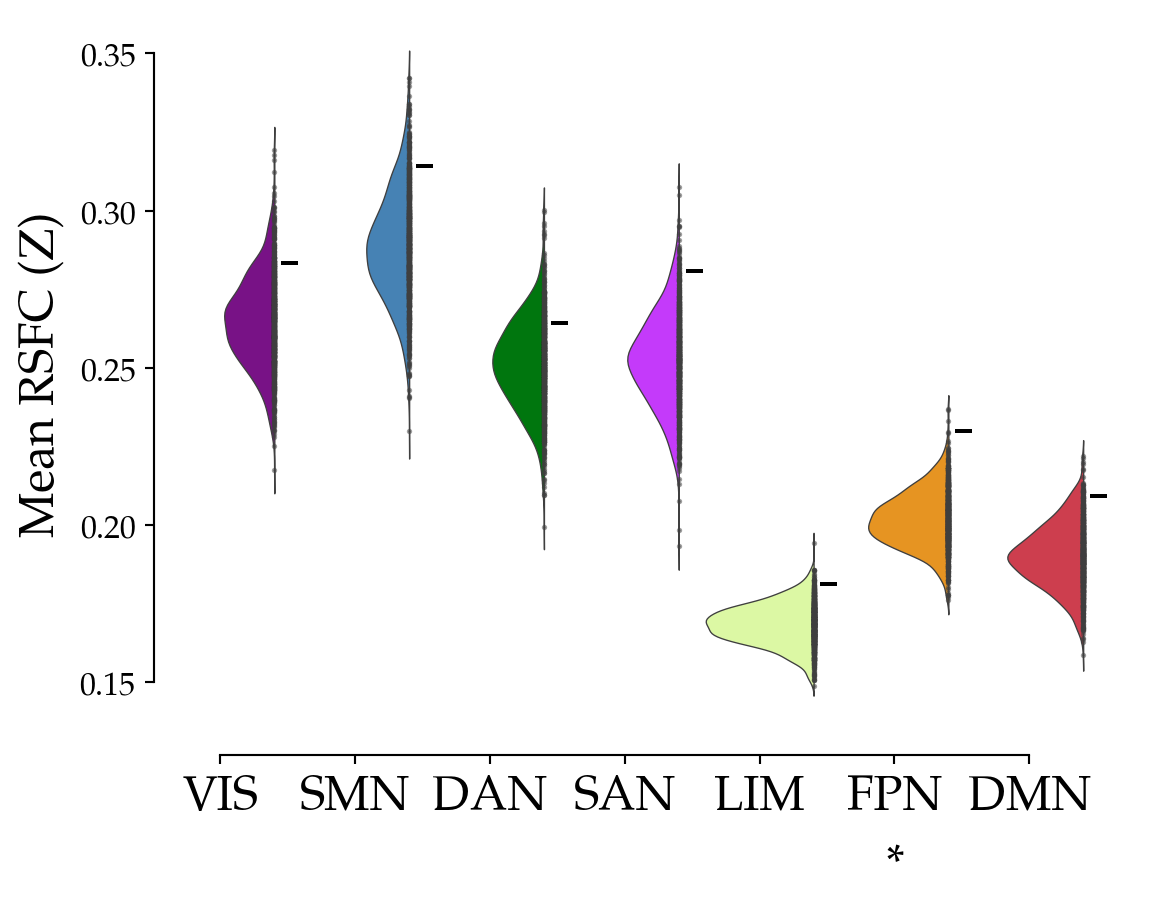

In [20]:
fig, ax = plt.subplots()
p_vals, true_fc_yeo , _ = ccm.ccm_yeo(true_fc, null_fcs, ax=ax)
yeo_map = io.load_yeo_map()
pd.DataFrame({'mean': true_fc_yeo.values.flatten(), 'p_vals': p_vals.values.flatten()}, index=yeo_map.shortnames[1:])

Plot the networks map on cortical surface:

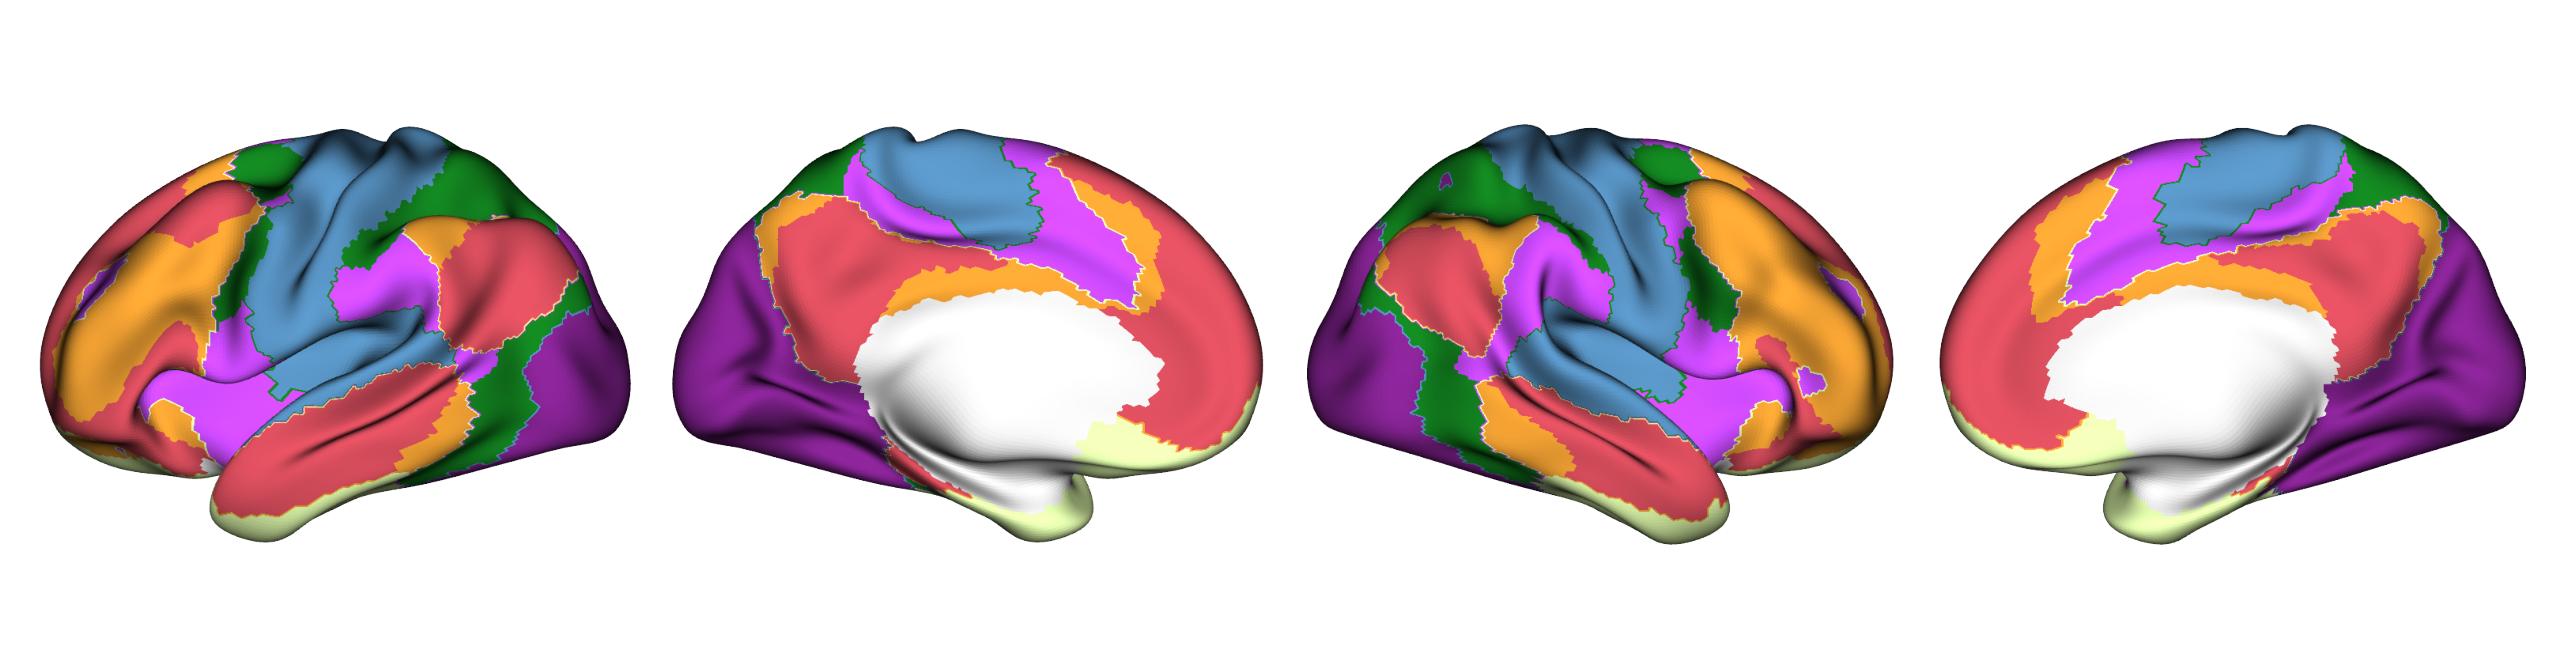

In [17]:
p = surfplot.Plot(surf_lh=plot.MESHES_FSLR['L'], surf_rh=plot.MESHES_FSLR['R'], 
             layout='row', size = (1600, 400), zoom = 1.2, brightness=0.8)
p.add_layer(yeo_map.cifti.get_fdata().flatten(), cmap=yeo_map.cmap, cbar=False)
p.build();